In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
import edward as ed
import edward.models as edm
from tensorflow.contrib.linalg import LinearOperatorTriL
import itertools
ds = tf.contrib.distributions

In [2]:
# http://edwardlib.org/tutorials/unsupervised
def build_toy_dataset(N):
  pi = np.array([0.3, 0.2,0.5])
  mus = [[1, 3], [-2, -5],[5,-3]]
  #stds = [[[0.1, 0.1], [0.1, 0.1]], [[0.1, 0.1], [0.1, 0.1]] ]\\
  stds = np.array([[[1,1.5], [1.5, 2.5]], [[1, 0], [0, 1]],[[2, -1.2], [-1.2, 2]] ])
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], stds[k,:,:])

  return x

N = 500  # number of data points
D = 2  # dimensionality of data

x_train = build_toy_dataset(N)

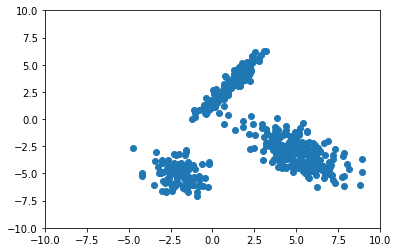

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-10, 10, -10, 10])
plt.show()

$$\text{Pr}(\textbf{x}_i|\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Sigma})=\sum_{k=1}^K \pi_k \text{N}(\textbf{x}_i|\mu_k,\Sigma_k)$$

$$\begin{aligned}
\pi_k\sim&\text{Dir}(\pi_k|\boldsymbol{\alpha})\\
\mu_k\sim&\text{N}(\mu_k|\boldsymbol{\mu}_0,\Sigma_0)\\
\Sigma_k\sim&\text{Wischart}(\nu_0,\Psi_0)
\end{aligned}$$

In [4]:
K = 3 # number of components
# priors
nu0 = tf.Variable(D, dtype=tf.float32, trainable=False)
psi0 = tf.Variable(np.eye(D),
                      dtype=tf.float32, trainable=False)
mu0 = tf.Variable(np.zeros(D), dtype=tf.float32, trainable=False)
sigma0 = tf.Variable(np.eye(D),
                      dtype=tf.float32, trainable=False)
pi = edm.Dirichlet(tf.ones(K))
sigma = edm.WishartCholesky(df=nu0, scale=psi0,cholesky_input_output_matrices=True,sample_shape=K)
mu = edm.MultivariateNormalTriL(mu0,sigma0,sample_shape=K)
#mu = edm.Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
cat = edm.Categorical(probs=pi,sample_shape=K)
# components = [
#     edm.MultivariateNormalDiag(mu[k], sigma[k], sample_shape=N)
#     for k in range(K)]
# x = edm.Mixture(cat=cat, components=components)

In [5]:
components = [
    edm.MultivariateNormalTriL(tf.gather(mu,k), 
                               tf.gather(sigma,k),sample_shape=N)
    for k in range(K)]

In [6]:
x = edm.Mixture(cat=cat, components=components,sample_shape=N)

In [7]:
qpsi0 = tf.Variable(tf.random_normal([K,D, D], dtype=tf.float32))
Ltril = LinearOperatorTriL(ds.matrix_diag_transform(qpsi0, transform=tf.nn.softplus)).to_dense()
qsigma=edm.WishartCholesky(df=tf.ones([K])*100,scale=Ltril)


In [8]:
qmu = edm.Normal(
    loc=tf.Variable(tf.random_normal([K, D])),
    scale=tf.nn.softplus(tf.Variable(tf.zeros([K, D]))))
#qmu0 = tf.Variable(tf.random_normal([K,D], dtype=tf.float32))
# qR = tf.Variable(tf.random_normal([K,D, D], dtype=tf.float32))
# #qmu = edm.MultivariateNormalTriL(qmu0, qR,sample_shape=K)
# qmu=tf.stack([edm.MultivariateNormalTriL(qmu0[k], qR[k]) for k in range(K)],axis=0)

In [9]:
inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={x: x_train}) # pi:qpi
inference.initialize(n_iter=2000, n_print=50, n_samples=30)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

{'t': 1, 'loss': 81789.898}
{'t': 51, 'loss': 3102.7441}
{'t': 101, 'loss': 2778.6619}
{'t': 151, 'loss': 2607.3647}
{'t': 201, 'loss': 2409.4385}
{'t': 251, 'loss': 2371.1042}
{'t': 301, 'loss': 2479.6611}
{'t': 351, 'loss': 2341.2671}
{'t': 401, 'loss': 2257.1438}
{'t': 451, 'loss': 2245.4783}
{'t': 501, 'loss': 2295.0068}
{'t': 551, 'loss': 2269.0354}
{'t': 601, 'loss': 2315.5691}
{'t': 651, 'loss': 2296.3799}
{'t': 701, 'loss': 2278.2112}
{'t': 751, 'loss': 2342.4753}
{'t': 801, 'loss': 2309.3694}
{'t': 851, 'loss': 2266.2664}
{'t': 901, 'loss': 2333.7766}
{'t': 951, 'loss': 2295.7739}
{'t': 1001, 'loss': 2305.095}
{'t': 1051, 'loss': 2317.6963}
{'t': 1101, 'loss': 2252.6716}
{'t': 1151, 'loss': 2305.7305}
{'t': 1201, 'loss': 2303.1594}
{'t': 1251, 'loss': 2309.7778}
{'t': 1301, 'loss': 2269.635}
{'t': 1351, 'loss': 2303.9089}
{'t': 1401, 'loss': 2289.7468}
{'t': 1451, 'loss': 2266.6313}
{'t': 1501, 'loss': 2322.2275}
{'t': 1551, 'loss': 2290.1362}
{'t': 1601, 'loss': 2308.2766}
{'

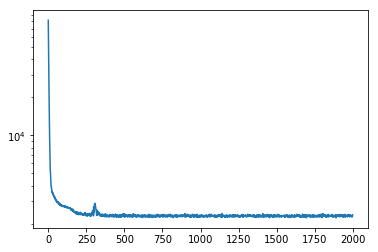

In [10]:
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%50 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)

In [11]:
qmu.loc.eval()

array([[ 1.06273675,  3.09721231],
       [ 0.48159429, -4.29892683],
       [ 5.07384729, -3.02314186]], dtype=float32)

In [12]:
LL0=Ltril[0].eval()
LL1=Ltril[1].eval()
LL2=Ltril[2].eval()
psi_eval0=np.matmul(LL0,np.transpose(LL0))

psi_eval1=np.matmul(LL1,np.transpose(LL1))

psi_eval2=np.matmul(LL2,np.transpose(LL2))

In [13]:
sigma_draws0=sps.wishart.rvs(100,psi_eval0,N)
sigma_draws1=sps.wishart.rvs(100,psi_eval1,N)
sigma_draws2=sps.wishart.rvs(100,psi_eval2,N)

In [14]:
mu_draws0=sps.multivariate_normal.rvs(qmu.loc[0].eval(),np.diag(qmu.scale[0].eval()),N)
mu_draws1=sps.multivariate_normal.rvs(qmu.loc[1].eval(),np.diag(qmu.scale[1].eval()),N)
mu_draws2=sps.multivariate_normal.rvs(qmu.loc[2].eval(),np.diag(qmu.scale[2].eval()),N)

In [15]:
x_draws0=np.zeros([N,2])
x_draws1=np.zeros([N,2])
x_draws2=np.zeros([N,2])

In [16]:
for i in range(N):
    x_draws0[i,:]=sps.multivariate_normal.rvs(mu_draws0[i,:],sigma_draws0[i,:,:])
    x_draws1[i,:]=sps.multivariate_normal.rvs(mu_draws1[i,:],sigma_draws1[i,:,:])
    x_draws2[i,:]=sps.multivariate_normal.rvs(mu_draws2[i,:],sigma_draws2[i,:,:])
    

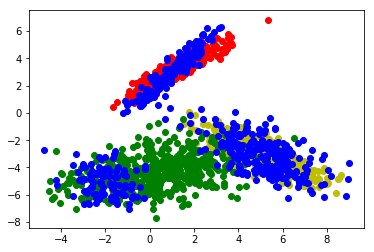

In [17]:
plt.plot(x_draws2[:,0],x_draws2[:,1],'yo',x_draws1[:,0],x_draws1[:,1],'go',x_draws0[:,0],x_draws0[:,1],'ro',x_train[:,0],x_train[:,1],'bo')

Let's include pi

In [19]:
qpi_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K])))
#pi = edm.Dirichlet(tf.ones([N,K]))
qpi = edm.Dirichlet(qpi_alpha)

In [20]:
inference2 = ed.KLqp({pi:qpi,mu: qmu, sigma: qsigma}, data={x: x_train}) # pi:qpi
inference2.initialize(n_iter=2000, n_print=50, n_samples=30)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

{'t': 1, 'loss': 11417.506}
{'t': 51, 'loss': 6963.3013}
{'t': 101, 'loss': 4899.7876}
{'t': 151, 'loss': 3670.1423}
{'t': 201, 'loss': 4629.686}
{'t': 251, 'loss': 5105.4995}
{'t': 301, 'loss': 19300.967}
{'t': 351, 'loss': 3574.0105}
{'t': 401, 'loss': 4646.4341}
{'t': 451, 'loss': 11564.399}
{'t': 501, 'loss': 7219.1104}
{'t': 551, 'loss': 24680.336}
{'t': 601, 'loss': 94791.977}
{'t': 651, 'loss': 104146.43}
{'t': 701, 'loss': 46842.449}
{'t': 751, 'loss': 77264.133}
{'t': 801, 'loss': 59105.391}
{'t': 851, 'loss': 52533.25}
{'t': 901, 'loss': 60703.059}
{'t': 951, 'loss': 56707.391}
{'t': 1001, 'loss': 60466.223}
{'t': 1051, 'loss': 58892.988}
{'t': 1101, 'loss': 53800.461}
{'t': 1151, 'loss': 60398.324}
{'t': 1201, 'loss': 61060.875}
{'t': 1251, 'loss': 55876.102}
{'t': 1301, 'loss': 53566.492}
{'t': 1351, 'loss': 53743.273}
{'t': 1401, 'loss': 55821.434}
{'t': 1451, 'loss': 62991.039}
{'t': 1501, 'loss': 56477.754}
{'t': 1551, 'loss': 57520.484}
{'t': 1601, 'loss': 55617.633}
{'

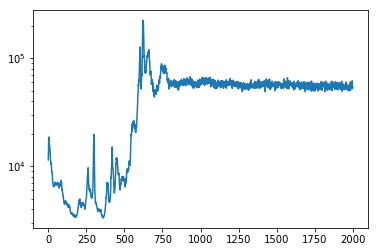

In [21]:
learning_curve = []
for _ in range(inference2.n_iter):
    info_dict = inference2.update()
    if _%50 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)

In [22]:
LL0=Ltril[0].eval()
LL1=Ltril[1].eval()
LL2=Ltril[2].eval()
psi_eval0=np.matmul(LL0,np.transpose(LL0))

psi_eval1=np.matmul(LL1,np.transpose(LL1))

psi_eval2=np.matmul(LL2,np.transpose(LL2))

In [23]:
sigma_draws0=sps.wishart.rvs(100,psi_eval0,N)
sigma_draws1=sps.wishart.rvs(100,psi_eval1,N)
sigma_draws2=sps.wishart.rvs(100,psi_eval2,N)

In [24]:
mu_draws0=sps.multivariate_normal.rvs(qmu.loc[0].eval(),np.diag(qmu.scale[0].eval()),N)
mu_draws1=sps.multivariate_normal.rvs(qmu.loc[1].eval(),np.diag(qmu.scale[1].eval()),N)
mu_draws2=sps.multivariate_normal.rvs(qmu.loc[2].eval(),np.diag(qmu.scale[2].eval()),N)

In [25]:
x_draws0=np.zeros([N,2])
x_draws1=np.zeros([N,2])
x_draws2=np.zeros([N,2])

In [26]:
for i in range(N):
    x_draws0[i,:]=sps.multivariate_normal.rvs(mu_draws0[i,:],sigma_draws0[i,:,:])
    x_draws1[i,:]=sps.multivariate_normal.rvs(mu_draws1[i,:],sigma_draws1[i,:,:])
    x_draws2[i,:]=sps.multivariate_normal.rvs(mu_draws2[i,:],sigma_draws2[i,:,:])
    

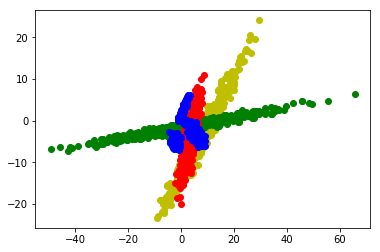

In [27]:
plt.plot(x_draws2[:,0],x_draws2[:,1],'yo',x_draws1[:,0],x_draws1[:,1],'go',x_draws0[:,0],x_draws0[:,1],'ro',x_train[:,0],x_train[:,1],'bo')